In [1]:
%matplotlib inline
from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
from dateutil.parser import parse
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [3]:
df = pd.read_csv('active_users.csv')
df

,time,google.accounts:num_1day_logins,google.accounts:num_7day_logins,google.accounts:num_30day_logins
0,2015-03-23T00:00:00.000-0400,16814,21763,24022
1,2015-03-24T00:00:00.000-0400,16591,21666,24069
2,2015-03-25T00:00:00.000-0400,16502,21530,24086
3,2015-03-26T00:00:00.000-0400,16899,21559,24121
4,2015-03-27T00:00:00.000-0400,15964,21636,24125
...,...,...,...,...
1584,2019-08-13T00:00:00.000-0400,4357,13600,24784
1585,2019-08-14T00:00:00.000-0400,4591,14007,24899
1586,2019-08-15T00:00:00.000-0400,4569,14399,25008
1587,2019-08-16T00:00:00.000-0400,4254,14781,25090


In [4]:

def time_set(df):
    import datetime as dt
    df[df.columns[0]] = pd.to_datetime(df[df.columns[0]],utc = True)
    df[df.columns[0]]= df.time.dt.date
    df.set_index(df.columns[0], inplace=True)
    return df


In [5]:
def plot(df,df0):
    df1 = df.copy()
    df2 = df0.copy()
    df1 = time_set(df1)
    df2 = time_set(df2)
    for x in range(len(df1.columns)):
        plt.figure(figsize=(22, 10))
        plt.plot(df1.index, df1[df1.columns[x]], label=df1.columns[x])
        plt.plot(df2.index, df2[df2.columns[x]], label='Prophet', color='r')
        plt.legend(loc='best', fontsize='xx-large')
        plt.show()

In [6]:
def timeprediction123(df,csvfilename):
    p = Prophet(yearly_seasonality=True, seasonality_mode='multiplicative', changepoint_prior_scale=0.7)
    #changepoint_prior changes the fit of the prediction
    df = df.rename(columns={df.columns[0]: "ds", df.columns[1]: "y"})
    
    df['ds'] = pd.to_datetime(df['ds'], utc=True)
    df['ds']= df.ds.dt.date
    df.index.freq = 'D'
    #get forecast

    p.fit(df)  # df is a pandas.DataFrame with 'y' and 'ds' columns
    future = p.make_future_dataframe(periods=365)
    time_pred = p.predict(future)
    df1 = time_pred[['ds','yhat']]
    df_cv = cross_validation(p, initial='370 days', period='100 days', horizon = '100 days')
    
    df_p = performance_metrics(df_cv)
    print("Performance head for " + csvfilename)
    print(df_p.head())
    print("Performance tail for " + csvfilename)
    print(df_p.tail())

    
    #df1.to_csv(data_path_write + csvfilename)
    df2 = time_pred[['yhat']]
    p.plot(time_pred)
    return df1,df2,time_pred

In [7]:
def timepredictionMAPE(df,csvfilename):
    p = Prophet(yearly_seasonality=True, seasonality_mode='multiplicative', changepoint_prior_scale=0.7)
    #changepoint_prior changes the fit of the prediction
    df = df.rename(columns={df.columns[0]: "ds", df.columns[1]: "y"})
    
    df['ds'] = pd.to_datetime(df['ds'], utc=True)
    df['ds']= df.ds.dt.date
    df.index.freq = 'D'
    #get forecast

    p.fit(df)  # df is a pandas.DataFrame with 'y' and 'ds' columns
    future = p.make_future_dataframe(periods=365)
    time_pred = p.predict(future)
    df1 = time_pred[['ds','yhat']]
    df_cv = cross_validation(p, initial='370 days', period='100 days', horizon = '100 days')
    try:
        print("MAPE for " + csvfilename + " predictions")
        fig = plot_cross_validation_metric(df_cv, metric='mape')
    except:
        print("MAPE way too low to be graphed, prediction is very good")
    df2 = time_pred[['yhat']]
    return df1,df2,time_pred

In [8]:
def send_prediction(df):
    df_with_all_preds = timeprediction123(df = df[['time', df.columns[1]]], csvfilename = df.columns[1])[0]
    df_with_all_preds = df_with_all_preds.rename(columns= {df_with_all_preds.columns[0] : "time", df_with_all_preds.columns[1] : df.columns[1]})
    df1= df.drop(columns= [df.columns[1]])
    
    for x in range(len(df1.columns) - 1):
        h =timeprediction123(df = df1[['time', df1.columns[x+1]]], csvfilename = df1.columns[x+1])[0]
        h =h.rename(columns = {h.columns[0]: "time", h.columns[1] : df1.columns[x+1]})
        df_with_all_preds =  df_with_all_preds.merge(h, on = "time")
    return df_with_all_preds

In [9]:
def send_predictionMAPE(df):
    df_with_all_preds = timepredictionMAPE(df = df[['time', df.columns[1]]], csvfilename = df.columns[1])[0]
    df_with_all_preds = df_with_all_preds.rename(columns= {df_with_all_preds.columns[0] : "time", df_with_all_preds.columns[1] : df.columns[1]})
    df1= df.drop(columns= [df.columns[1]])
    
    for x in range(len(df1.columns) - 1):
        h =timepredictionMAPE(df = df1[['time', df1.columns[x+1]]], csvfilename = df1.columns[x+1])[0]
        h =h.rename(columns = {h.columns[0]: "time", h.columns[1] : df1.columns[x+1]})
        df_with_all_preds =  df_with_all_preds.merge(h, on = "time")
    return df_with_all_preds

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 12 forecasts with cutoffs between 2016-05-04 00:00:00 and 2019-05-09 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance head for google.accounts:num_1day_logins 
  horizon           mse         rmse          mae      mape  coverage
0 11 days  2.242778e+06  1497.590742  1143.712248  0.223006  0.611582
1 12 days  2.442391e+06  1562.815158  1179.928180  0.223237  0.614407
2 13 days  2.394619e+06  1547.455712  1173.778137  0.216247  0.629944
3 14 days  2.819488e+06  1679.133042  1223.456790  0.211598  0.621469
4 15 days  2.577855e+06  1605.569873  1156.387132  0.194773  0.641243
Performance tail for google.accounts:num_1day_logins 
    horizon           mse         rmse          mae      mape  coverage
85  96 days  1.811193e+07  4255.811395  3447.713332  0.618268  0.399718
86  97 days  1.879024e+07  4334.770839  3519.077670  0.624461  0.411017
87  98 days  1.901390e+07  4360.492872  3543.381663  0.614743  0.426554
88  99 days  1.835587e+07  4284.375158  3484.896034  0.599833  0.433616
89 100 days  1.773609e+07  4211.424187  3455.993813  0.594926  0.433616


INFO:fbprophet:Making 12 forecasts with cutoffs between 2016-05-04 00:00:00 and 2019-05-09 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance head for google.accounts:num_7day_logins
  horizon           mse         rmse          mae      mape  coverage
0 11 days  1.704729e+06  1305.652822   986.435663  0.062894  0.555085
1 12 days  1.998793e+06  1413.786622  1060.906945  0.067228  0.512712
2 13 days  2.346786e+06  1531.922341  1144.319814  0.072123  0.471751
3 14 days  3.057338e+06  1748.524400  1257.119621  0.077958  0.429379
4 15 days  3.410873e+06  1846.854846  1323.976202  0.081846  0.439266
Performance tail for google.accounts:num_7day_logins
    horizon           mse         rmse          mae      mape  coverage
85  96 days  2.844578e+07  5333.458407  3926.840087  0.233231  0.583333
86  97 days  2.912619e+07  5396.868571  3981.833664  0.236383  0.583333
87  98 days  2.983613e+07  5462.245667  4027.347177  0.238771  0.591808
88  99 days  3.040748e+07  5514.297513  4056.423134  0.240227  0.600282
89 100 days  3.088113e+07  5557.079166  4068.739120  0.240377  0.608757


INFO:fbprophet:Making 12 forecasts with cutoffs between 2016-05-04 00:00:00 and 2019-05-09 00:00:00


Performance head for google.accounts:num_30day_logins
  horizon            mse        rmse         mae      mape  coverage
0 11 days  234477.404612  484.228670  353.883994  0.014907  0.348870
1 12 days  282569.401578  531.572574  379.828782  0.016067  0.332627
2 13 days  319610.868732  565.341374  401.529458  0.017026  0.327684
3 14 days  327906.092746  572.630852  411.543281  0.017415  0.324859
4 15 days  327023.012239  571.859259  403.004084  0.017036  0.357345
Performance tail for google.accounts:num_30day_logins
    horizon           mse         rmse          mae      mape  coverage
85  96 days  6.726386e+06  2593.527669  2047.593288  0.083746  0.790960
86  97 days  7.007771e+06  2647.219403  2093.113608  0.085688  0.782486
87  98 days  7.294384e+06  2700.811718  2136.832690  0.087560  0.774011
88  99 days  7.602775e+06  2757.312938  2182.407929  0.089527  0.765537
89 100 days  7.942257e+06  2818.200942  2232.496539  0.091697  0.766949


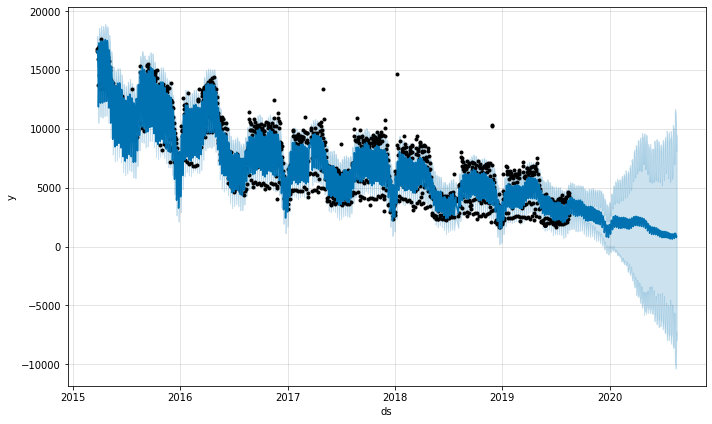

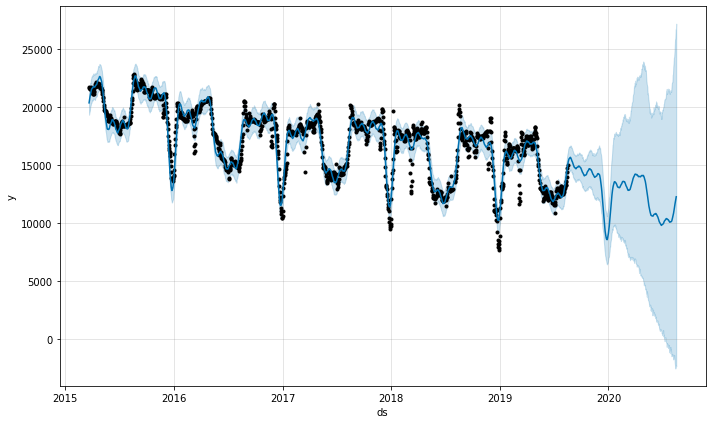

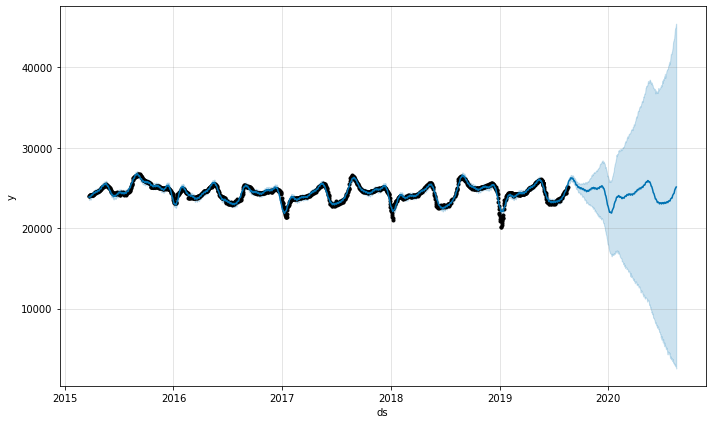

In [10]:
prediction = send_prediction(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 12 forecasts with cutoffs between 2016-05-04 00:00:00 and 2019-05-09 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE for google.accounts:num_1day_logins  predictions


INFO:fbprophet:Making 12 forecasts with cutoffs between 2016-05-04 00:00:00 and 2019-05-09 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE for google.accounts:num_7day_logins predictions


INFO:fbprophet:Making 12 forecasts with cutoffs between 2016-05-04 00:00:00 and 2019-05-09 00:00:00


MAPE for google.accounts:num_30day_logins predictions


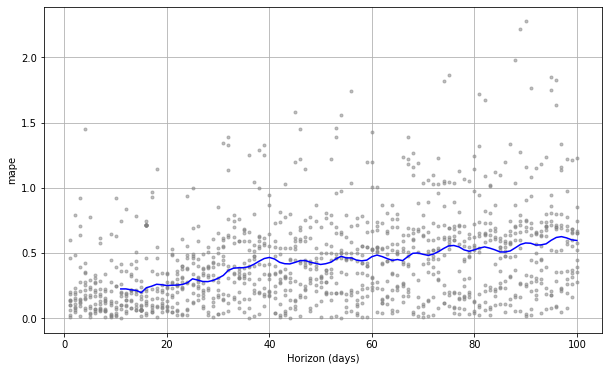

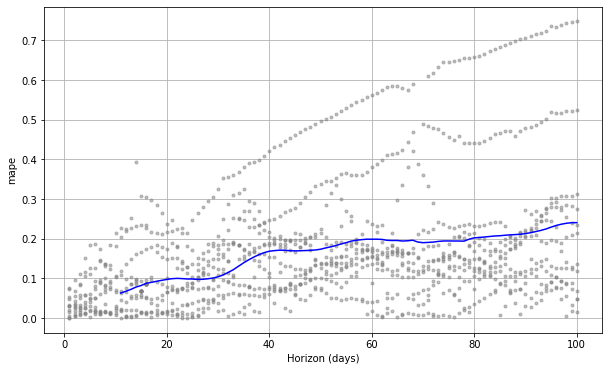

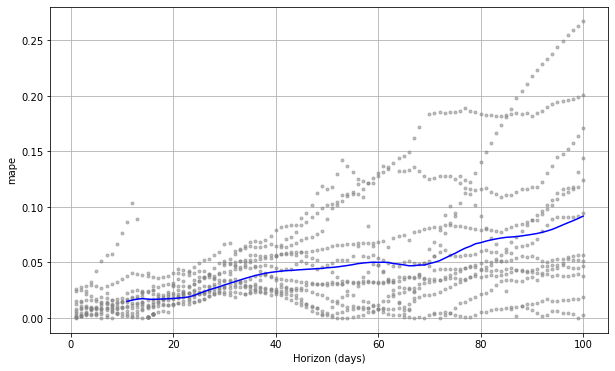

In [11]:
prediction1 = send_predictionMAPE(df)

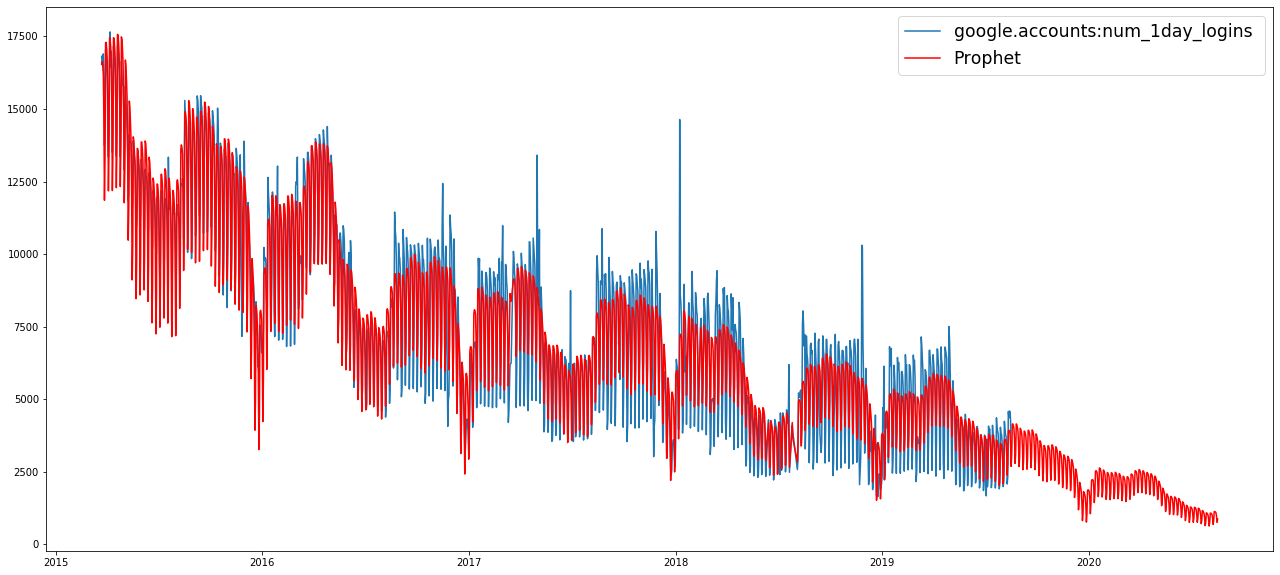

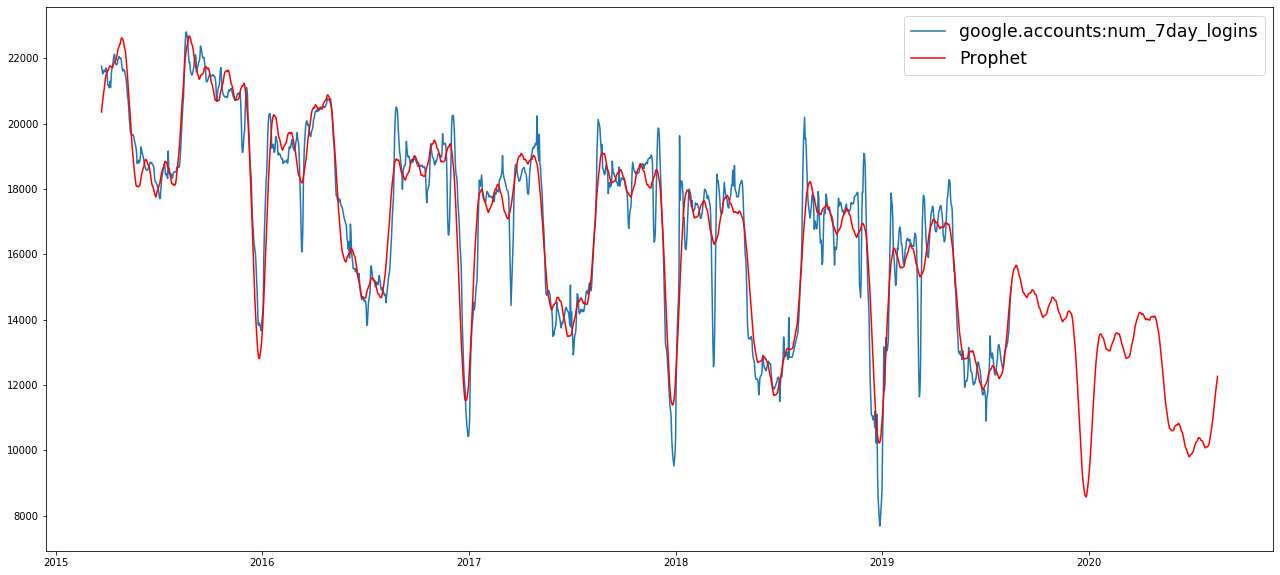

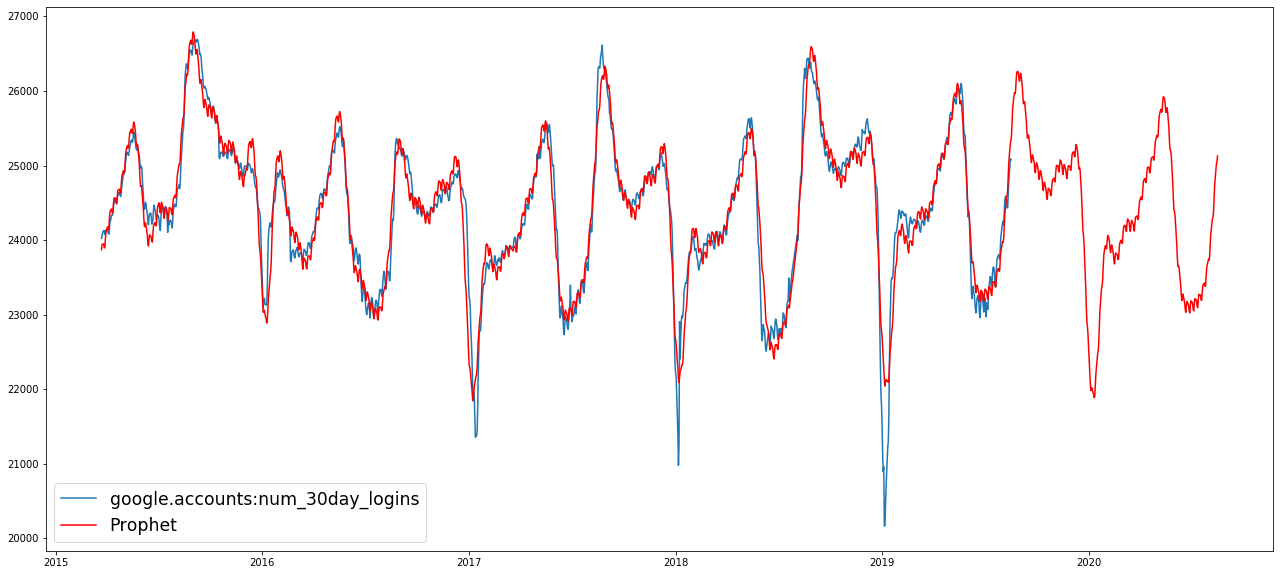

In [12]:
plot(df,prediction)